In [1]:
# Introduction

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
from keras.preprocessing import image
import os
from os.path import join
import matplotlib.pyplot as plt

input_size = 512
data_dir = 'C:\\Temp\\BigData\\Image masking\\'
np.random.seed(1987)

Using TensorFlow backend.


In [3]:
# read training data 
# use 5000 sample images from the data provided.
X_train = pd.read_csv(join(data_dir, 'train_masks.csv'), usecols=['img'])
X_train['img_id'] = X_train['img'].map(lambda s: s.split('.')[0])
X_train.head(3)

,img,img_id
0,00087a6bd4dc_01.jpg,00087a6bd4dc_01
1,00087a6bd4dc_02.jpg,00087a6bd4dc_02
2,00087a6bd4dc_03.jpg,00087a6bd4dc_03


In [4]:
## Read and show images and masks

In [5]:
#training images in jpg format and mask files in gif files
def get_image_and_mask(img_id):
    if os.path.exists(join(data_dir, 'train', '%s.jpg' % img_id)):
        img = image.load_img(join(data_dir, 'train', '%s.jpg' % img_id),
                             target_size=(input_size, input_size))
        img = image.img_to_array(img)
    if os.path.exists(join(data_dir, 'train_masks', '%s_mask.gif' % img_id)):
        mask = image.load_img(join(data_dir, 'train_masks', '%s_mask.gif' % img_id),
                              grayscale=True, target_size=(input_size, input_size))
        mask = image.img_to_array(mask)
        img, mask = img / 255., mask / 255.
        return img, mask

def plot_img_and_mask(img, mask):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [6]:
img_ids = X_train['img_id'].values
np.random.shuffle(img_ids)
img_id = img_ids[0]
img, mask = get_image_and_mask(img_id)
print((img.shape, mask.shape))

((512, 512, 3), (512, 512, 1))


In [7]:
# Pixel Transformations for understanding image of the product.
# It could be zoom image, contrast, capture image and mask

In [8]:
def plot_img_and_mask_transformed(img, mask, img_tr, mask_tr):
    fig, axs = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    axs[2].imshow(img_tr)
    axs[3].imshow(mask_tr[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [9]:
## Flip the image randomly
# one particular image and while creating mask so as to capture boundaries clearly.
# then images and boundaries are captured.

In [10]:
def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    return img, mask

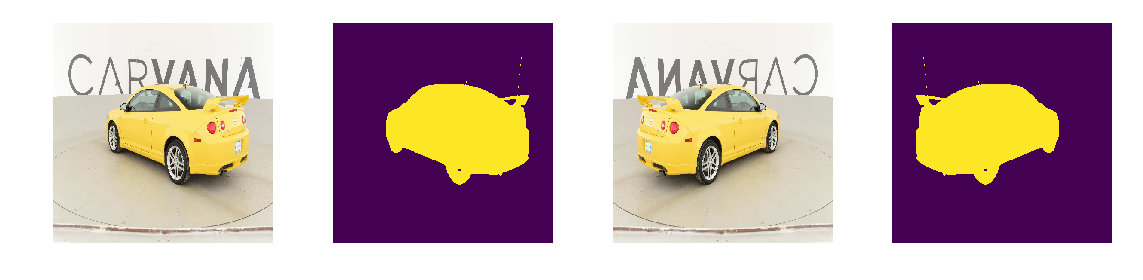

In [11]:
img_flip, mask_flip = random_flip(img, mask, u=1)
plot_img_and_mask_transformed(img, mask, img_flip, mask_flip)

In [12]:
## Rotate the image
# Rotating the image in 180 degrees, to get more information (example engine), this will help in understanding the data.

In [13]:
def rotate(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
        mask = rotate(mask, theta)
    return img, mask

theta 0.29


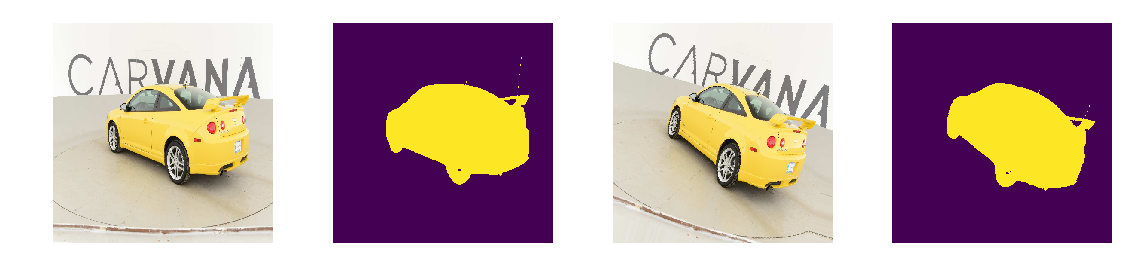

In [14]:
rotate_limit=(-30, 30)
theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
print('theta %.2f' % theta)
img_rot = rotate(img, theta)
mask_rot = rotate(mask, theta)
plot_img_and_mask_transformed(img, mask, img_rot, mask_rot)

In [15]:
## If the image is shifted by height and width, will the model work ?
# yes, the model works, since image is identifed and created by shift function based on row access level of zero.

In [16]:
def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask

wshift: 0.14, hshift: -0.10


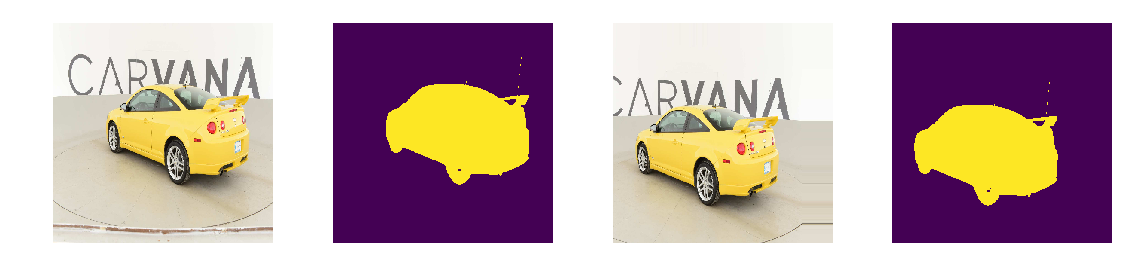

In [17]:
w_limit=(-0.2, 0.2)
h_limit=(-0.2, 0.2)
wshift = np.random.uniform(w_limit[0], w_limit[1])
hshift = np.random.uniform(h_limit[0], h_limit[1])
print('wshift: %.2f, hshift: %.2f' % (wshift, hshift))
img_shift = shift(img, wshift, hshift)
mask_shift = shift(mask, wshift, hshift)
plot_img_and_mask_transformed(img, mask, img_shift, mask_shift)

In [18]:
## Zoom the image
# height and width in terms of pixel, this will help understand the images.
# since carvana takes 16 images in different format,
# check image in each and every format, so image is recognized.

In [19]:
def zoom(x, zx, zy, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(zoom_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = zoom(img, zx, zy)
        mask = zoom(mask, zx, zy)
    return img, mask

zx: 0.92, zy: 0.90


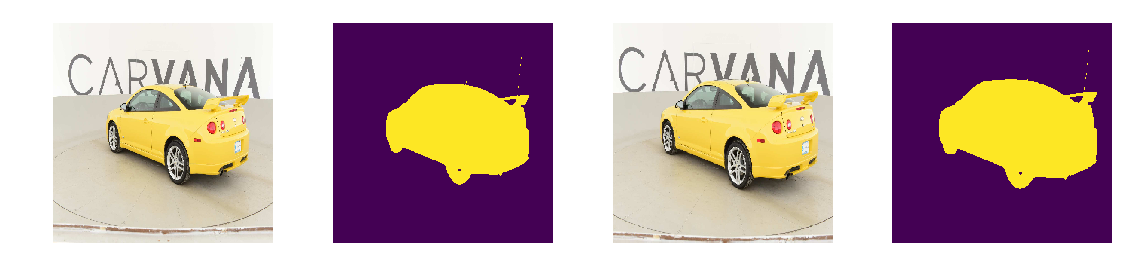

In [20]:
zoom_range=(0.7, 1)
zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
print('zx: %.2f, zy: %.2f' % (zx, zy))
img_zoom = zoom(img, zx, zy)
mask_zoom = zoom(mask, zx, zy)
plot_img_and_mask_transformed(img, mask, img_zoom, mask_zoom)

In [21]:
## Shear

In [22]:
def shear(x, shear, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(shear_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = shear(img, sh)
        mask = shear(mask, sh)
    return img, mask

sh: 0.44


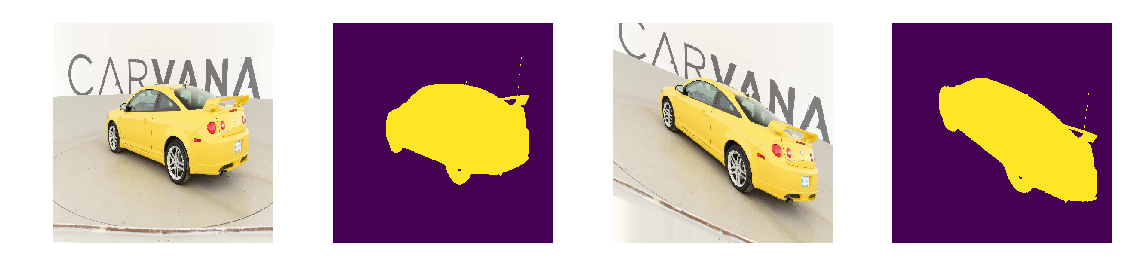

In [23]:
intensity = 0.5
sh = np.random.uniform(-intensity, intensity)
print('sh: %.2f' % sh)
img_shear = shear(img, sh)
mask_shear = shear(mask, sh)
plot_img_and_mask_transformed(img, mask, img_shear, mask_shear)

In [24]:
# Color transformations
# increase brightness, contrast, saturation of the data from positive to negative
# how well it can understand
# width 10 and height 5

In [25]:
def plot_img_transformed(img, img_tr):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(img_tr)
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [26]:
## Random channel shift
# provide two channel access
# original image and the transformed image

In [27]:
def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

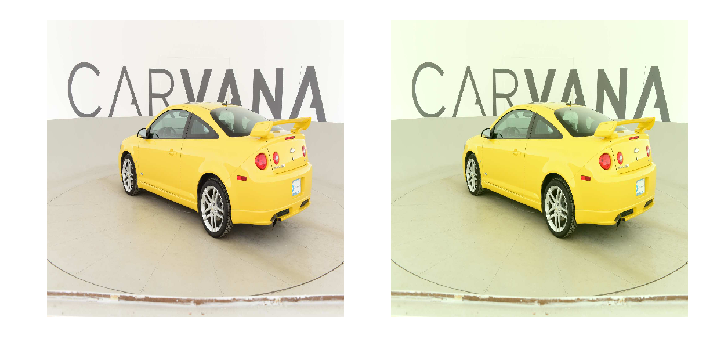

In [28]:
img_chsh = random_channel_shift(img, limit=0.05)
plot_img_transformed(img, img_chsh)

In [29]:
## Grayscale
# transform image into grayscale
# create new image on axis 2

In [30]:
def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

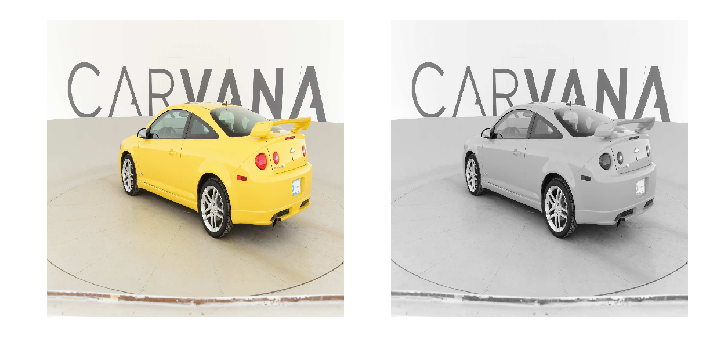

In [31]:
img_gray = random_gray(img, u=1)
plot_img_transformed(img, img_gray)

In [32]:
## Contrast
# increase or decrease contrast

In [33]:
def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

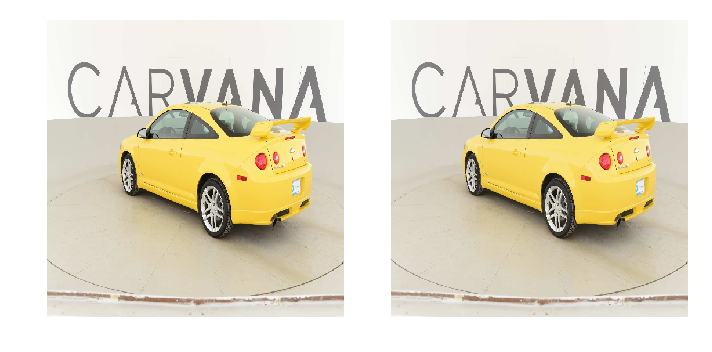

In [34]:
img_contrast = random_contrast(img, u=1)
plot_img_transformed(img, img_contrast)

In [35]:
## Brightness
# increase or decrease brightness

In [36]:
def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

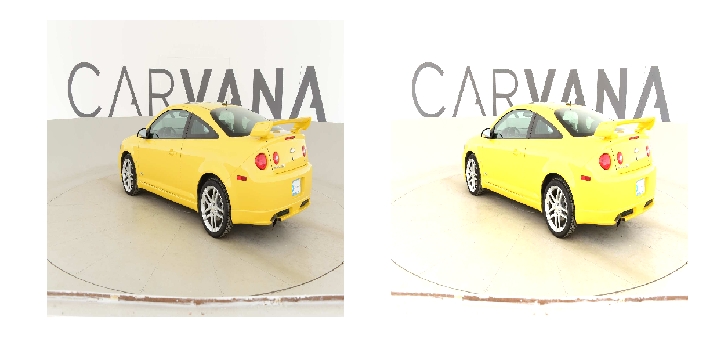

In [37]:
img_brightness = random_brightness(img, u=1)
plot_img_transformed(img, img_brightness)

In [38]:
## Saturation

In [39]:
def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

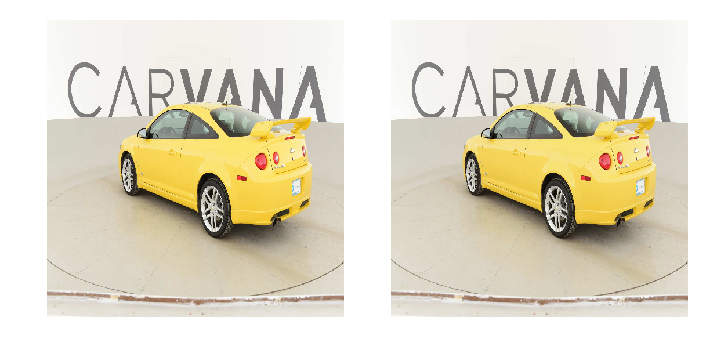

In [40]:
img_sat = random_saturation(img, u=1)
plot_img_transformed(img, img_sat)

In [41]:
# All together
# The limits here were chosen to have visible effects using less transformations and lower limits in the pipeline.

In [42]:
def plot_img_and_mask_transformed3(img, mask, img_tr1, mask_tr1, img_tr2, mask_tr2):
    fig, axs = plt.subplots(ncols=6, figsize=(30, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    axs[2].imshow(img_tr1)
    axs[3].imshow(mask_tr1[:, :, 0])
    axs[4].imshow(img_tr2)
    axs[5].imshow(mask_tr2[:, :, 0])
    for ax in axs:
        ax.set_xlim(0, input_size)
        ax.axis('off')
    fig.tight_layout()
    plt.show()

In [43]:
#creating function to understand the analysis performed on an image.
def random_augmentation(img, mask):
    img = random_channel_shift(img, limit=0.05)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    img, mask = random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5)
    img, mask = random_shear(img, mask, intensity_range=(-0.3, 0.3), u=0.2)
    img, mask = random_flip(img, mask, u=0.3)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.3)
    img, mask = random_zoom(img, mask, zoom_range=(0.8, 1), u=0.3)
    return img, mask

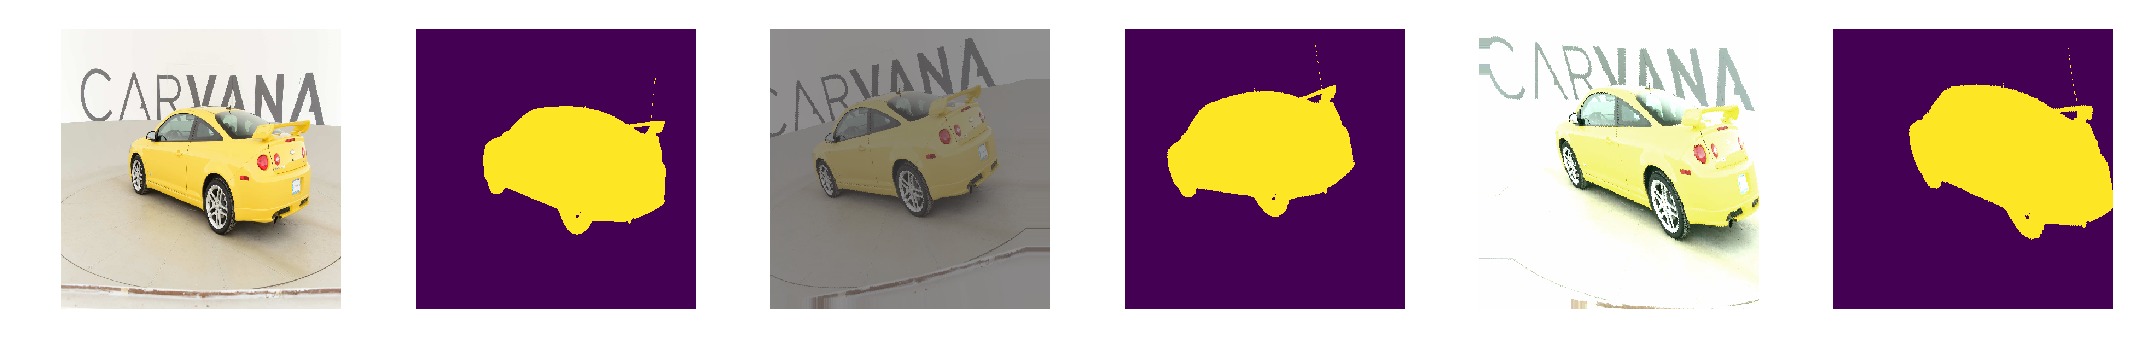

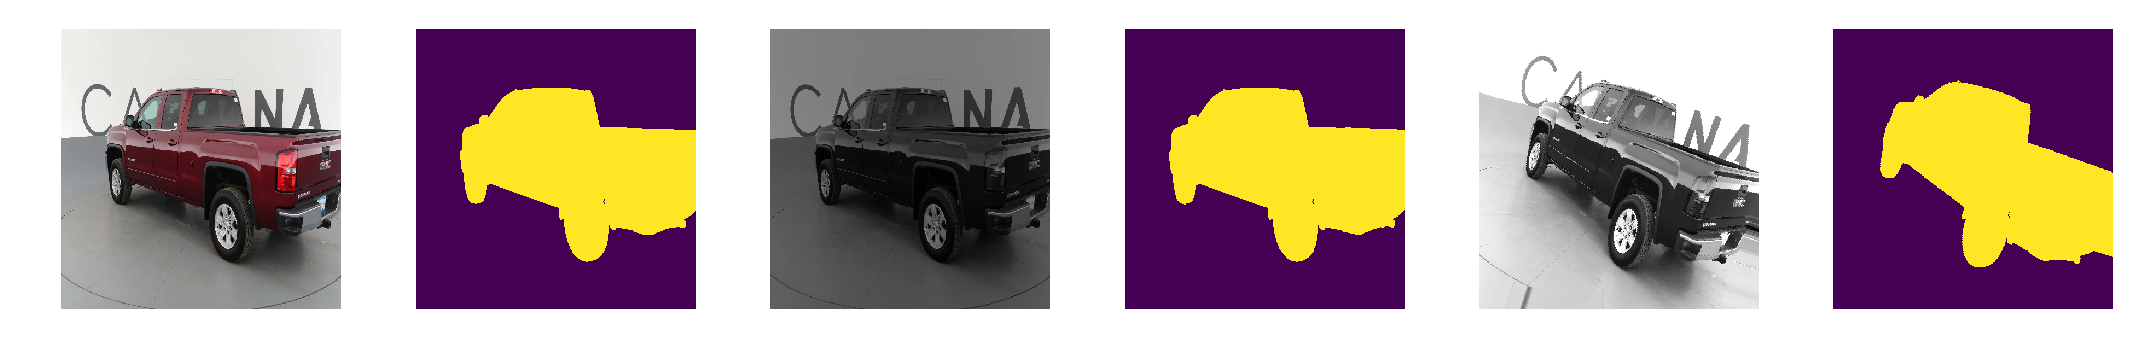

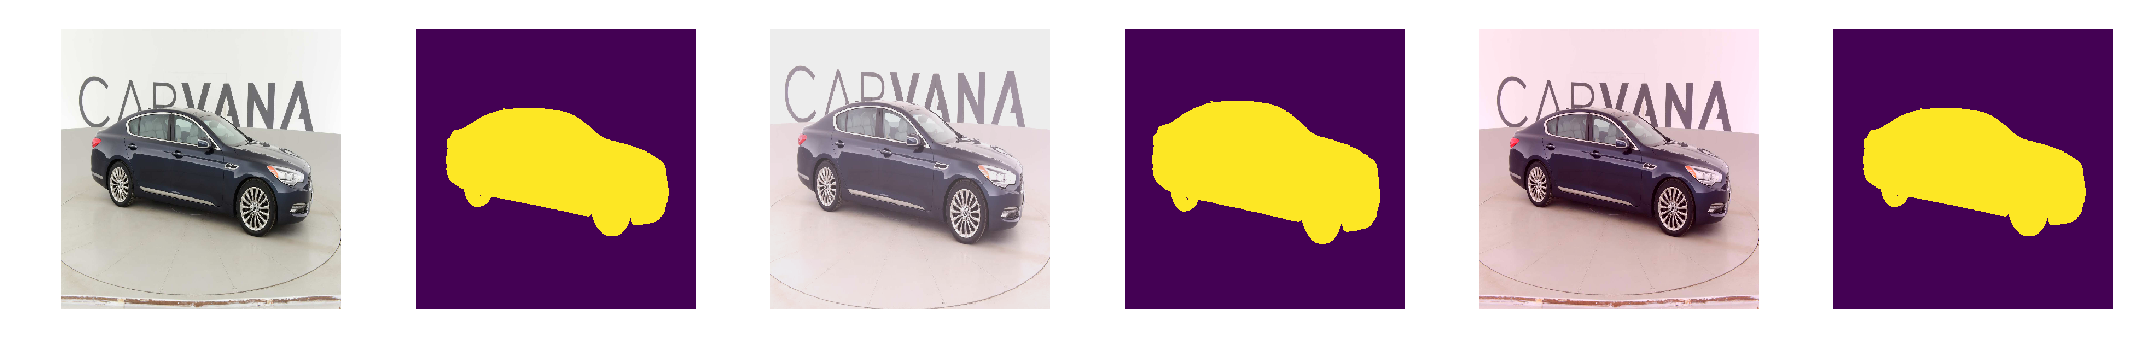

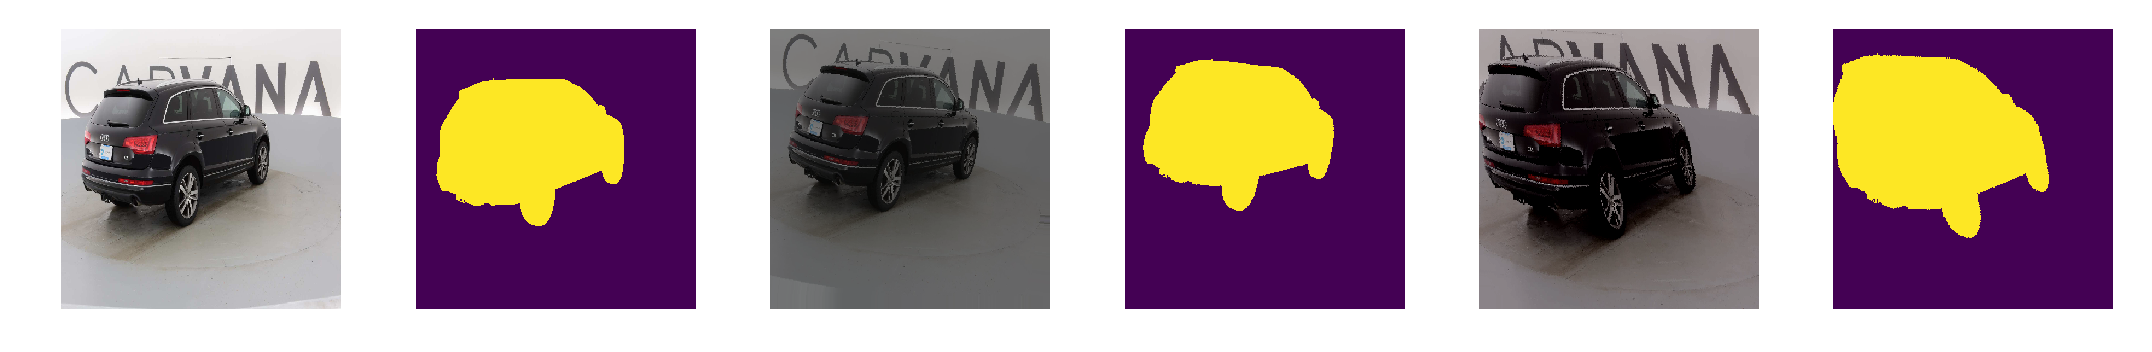

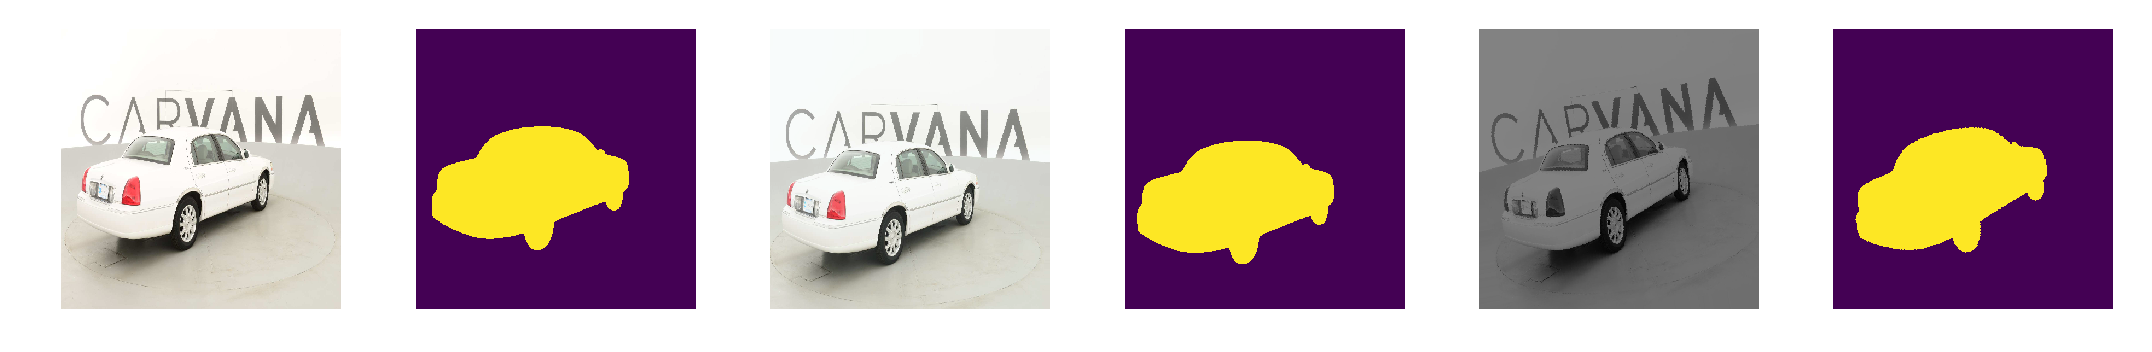

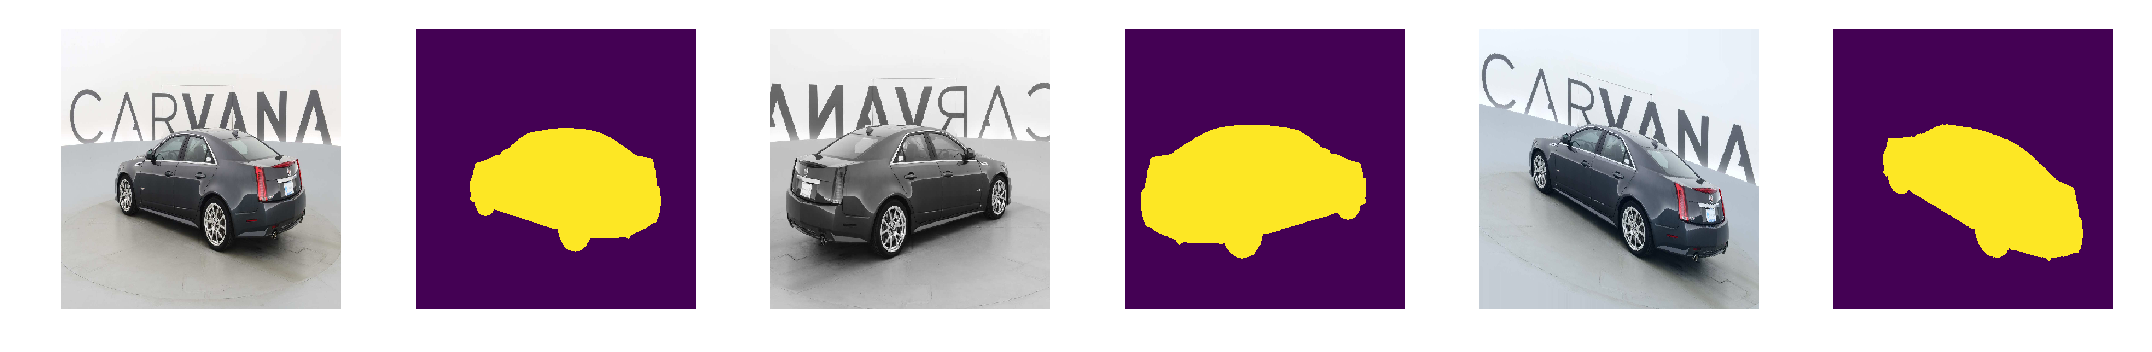

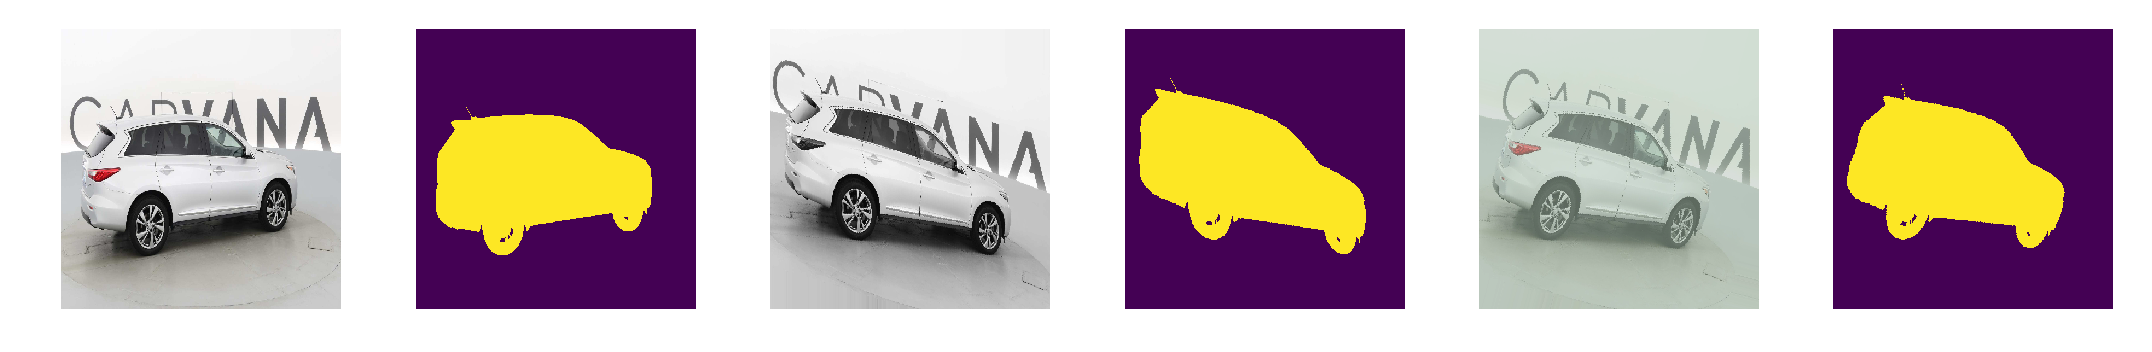

In [45]:
for img_id in img_ids[:16]:
    if os.path.exists(join(data_dir, 'train', '%s.jpg' % img_id)):
        img, mask = get_image_and_mask(img_id)
        img_aug1, mask_aug1 = random_augmentation(img, mask)
        img_aug2, mask_aug2 = random_augmentation(img, mask)
        plot_img_and_mask_transformed3(img, mask, img_aug1, mask_aug1, img_aug2, mask_aug2)
    else:
        pass